In [1]:
!pip install tensorflow numpy

In [2]:
!pip install opencv-python

In [3]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [4]:
print("Loading MNIST dataset...")
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


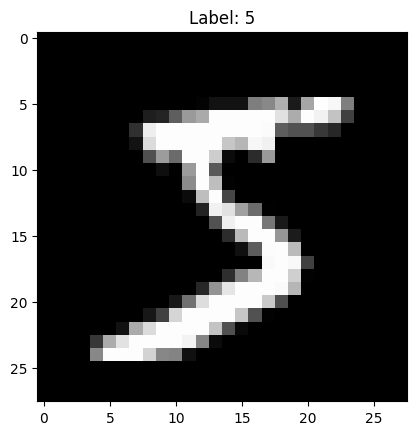

In [5]:
# Normalize to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Add channel dimension: (N, 28, 28) -> (N, 28, 28, 1)
train_images = train_images[..., None]
test_images = test_images[..., None]

plt.imshow(train_images[0, :, :, 0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()


In [6]:
def create_cnn_model():
    model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
    return model




In [7]:
model = create_cnn_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
print("Training the model on Task A...")
model.fit(train_images, train_labels, epochs=5, batch_size=128, validation_split=0.1)

acc_A_before = model.evaluate(test_images, test_labels, verbose=0)[1]
print("Task A accuracy before Task B:", acc_A_before)


Training the model on Task A...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 63s 145ms/step - accuracy: 0.8019 - loss: 0.6287 - val_accuracy: 0.9827 - val_loss: 0.0636
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 60s 143ms/step - accuracy: 0.9656 - loss: 0.1138 - val_accuracy: 0.9878 - val_loss: 0.0430
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 61s 145ms/step - accuracy: 0.9734 - loss: 0.0863 - val_accuracy: 0.9898 - val_loss: 0.0379
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 63s 149ms/step - accuracy: 0.9805 - loss: 0.0642 - val_accuracy: 0.9895 - val_loss: 0.0365
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 61s 145ms/step - accuracy: 0.9826 - loss: 0.0535 - val_accuracy: 0.9918 - val_loss: 0.0315
Task A accuracy before Task B: 0.9904000163078308


In [8]:

predictions = model.predict(test_images[:1])
print(predictions)
print(f'\n the predicted digit is {predictions[0].argmax()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[[5.2916183e-10 7.8415796e-10 5.5613349e-08 3.9117372e-09 9.0013700e-12
  4.9874042e-11 5.1676274e-14 9.9999905e-01 7.2985817e-10 1.0037232e-06]]

 the predicted digit is 7


In [9]:
def permute_mnist(images, seed=0):
    np.random.seed(seed)
    perm = np.random.permutation(28 * 28)
    images_flat = images.reshape(-1, 28 * 28)
    images_perm = images_flat[:, perm]
    return images_perm.reshape(-1, 28, 28, 1)

train_images_B = permute_mnist(train_images, seed=42)
test_images_B = permute_mnist(test_images, seed=42)



In [10]:
print("Compiling the model for Task B...")
model.fit(train_images_B, train_labels,
          epochs=5,
          batch_size=128)

acc_A_after = model.evaluate(test_images, test_labels, verbose=0)[1]
acc_B = model.evaluate(test_images_B, test_labels, verbose=0)[1]

Compiling the model for Task B...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - accuracy: 0.7093 - loss: 0.8936
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 142ms/step - accuracy: 0.9080 - loss: 0.2988
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - accuracy: 0.9283 - loss: 0.2309
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 141ms/step - accuracy: 0.9369 - loss: 0.1988
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 140ms/step - accuracy: 0.9451 - loss: 0.1760


In [11]:
forgetting_baseline = acc_A_before - acc_A_after
avg_acc_baseline = (acc_A_after + acc_B) / 2

print("Results without mitigation")
print("Task A after Task B:", acc_A_after)
print("Task B accuracy:", acc_B)
print("Forgetting:", forgetting_baseline)


Results without mitigation
Task A after Task B: 0.6894999742507935
Task B accuracy: 0.963100016117096
Forgetting: 0.30090004205703735


In [12]:
buffer_size = 2000
buffer_images = train_images[:buffer_size]
buffer_labels = train_labels[:buffer_size]

In [13]:
model_rehearsal = create_cnn_model()
model_rehearsal.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train Task A
model_rehearsal.fit(train_images, train_labels,
                    epochs=5,
                    batch_size=128)

acc_A_before_r = model_rehearsal.evaluate(
    test_images, test_labels, verbose=0)[1]

# mixed replay
mixed_images = np.concatenate([train_images_B, buffer_images])
mixed_labels = np.concatenate([train_labels, buffer_labels])
print(mixed_images.shape, mixed_labels.shape)

model_rehearsal.fit(mixed_images, mixed_labels,
                    epochs=5,
                    batch_size=128)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 139ms/step - accuracy: 0.7995 - loss: 0.6209
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 138ms/step - accuracy: 0.9683 - loss: 0.1093
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 0.9762 - loss: 0.0787
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 141ms/step - accuracy: 0.9827 - loss: 0.0582
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 143ms/step - accuracy: 0.9846 - loss: 0.0517
(62000, 28, 28, 1) (62000,)
Epoch 1/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 68s 140ms/step - accuracy: 0.7484 - loss: 0.7833
Epoch 2/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 84s 145ms/step - accuracy: 0.9158 - loss: 0.2775
Epoch 3/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 70s 145ms/step - accuracy: 0.9323 - loss: 0.2173
Epoch 4/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 83s 146ms/step - accuracy: 0.9436 - loss: 0.1818
Epoch 5/5
485/485 ━━━━━━━━━━━━━━━━━━━━ 69s 143ms/step - accuracy: 0.9511 - loss: 0.1556


In [14]:
acc_A_after_r = model_rehearsal.evaluate(
    test_images, test_labels, verbose=0)[1]

acc_B_r = model_rehearsal.evaluate(
    test_images_B, test_labels, verbose=0)[1]


forgetting_rehearsal = acc_A_before_r - acc_A_after_r
avg_acc_rehearsal = (acc_A_after_r + acc_B_r) / 2
print("Results with rehearsal mitigation")
print("Task A after Task B:", acc_A_after_r)
print("Task B accuracy:", acc_B_r)
print("Forgetting:", forgetting_rehearsal)


Results with rehearsal mitigation
Task A after Task B: 0.9868000149726868
Task B accuracy: 0.967199981212616
Forgetting: 0.004700005054473877


In [15]:
# EWC method Elastic Weight Consolidation
model_reg = create_cnn_model()
model_reg.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_reg.fit(train_images, train_labels,
              epochs=5,
              batch_size=128)

old_weights = model_reg.get_weights()
lambda_ewc = 0.01

# computing EWC
def ewc_loss(y_true, y_pred):
    base_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred)
    reg_loss = 0
    for w, w_old in zip(model_reg.trainable_weights, old_weights):
        reg_loss += tf.reduce_sum(tf.square(w - w_old))
    return base_loss + lambda_ewc * reg_loss


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 140ms/step - accuracy: 0.8011 - loss: 0.6200
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 137ms/step - accuracy: 0.9682 - loss: 0.1068
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 139ms/step - accuracy: 0.9767 - loss: 0.0800
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 139ms/step - accuracy: 0.9819 - loss: 0.0599
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.9846 - loss: 0.0509


In [16]:
model_reg.compile(
    optimizer='adam',
    loss=ewc_loss,
    metrics=['accuracy']
)

model_reg.fit(train_images_B, train_labels,
              epochs=5,
              batch_size=128)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 144ms/step - accuracy: 0.6102 - loss: 1.4050
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 143ms/step - accuracy: 0.8076 - loss: 0.9533
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 144ms/step - accuracy: 0.8218 - loss: 0.9195
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - accuracy: 0.8263 - loss: 0.9095
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.8332 - loss: 0.9055


In [17]:
acc_A_after_reg = model_reg.evaluate(
    test_images, test_labels, verbose=0)[1]
acc_B_reg = model_reg.evaluate(
    test_images_B, test_labels, verbose=0)[1]

forgetting_reg = acc_A_before - acc_A_after_reg
avg_acc_reg = (acc_A_after_reg + acc_B_reg) / 2
print("Results with EWC mitigation")
print("Task A after Task B:", acc_A_after_reg)
print("Task B accuracy:", acc_B_reg)
print("Forgetting:", forgetting_reg)


Results with EWC mitigation
Task A after Task B: 0.9448999762535095
Task B accuracy: 0.909500002861023
Forgetting: 0.04550004005432129


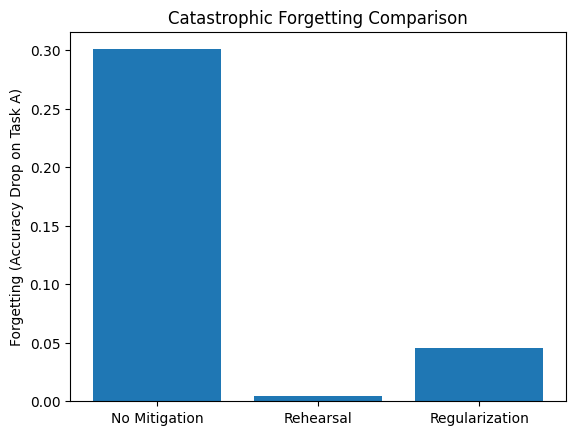

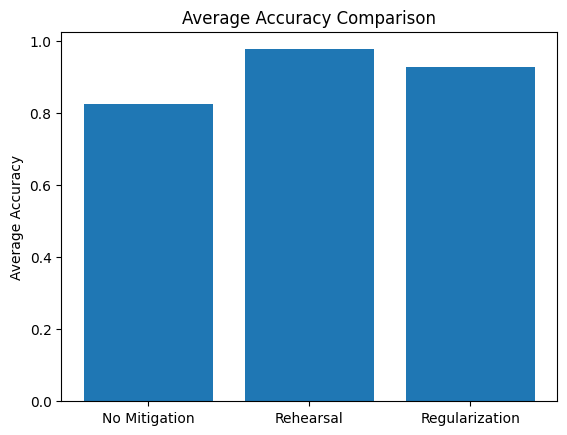

In [18]:
methods = ['No Mitigation', 'Rehearsal', 'Regularization']
forgetting_values = [
    forgetting_baseline,
    forgetting_rehearsal,
    forgetting_reg
]
avg_acc_values = [
    avg_acc_baseline,
    avg_acc_rehearsal,
    avg_acc_reg
    
]
plt.figure()
plt.bar(methods, forgetting_values)
plt.ylabel("Forgetting (Accuracy Drop on Task A)")
plt.title("Catastrophic Forgetting Comparison")
plt.show()

# Average Accuracy Plot
plt.figure()
plt.bar(methods, avg_acc_values)
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy Comparison")
plt.show()
              
